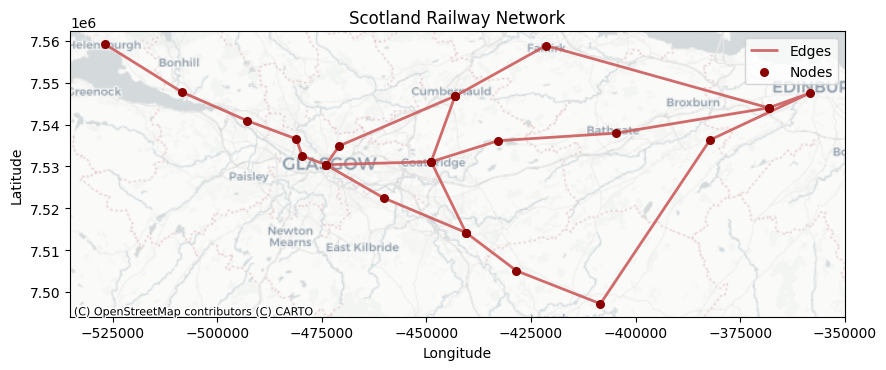

In [1]:
import itertools
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import LineString
import pandas as pd
import time
from scipy.stats import multivariate_normal, norm
from itertools import combinations
import numpy as np

# Define file paths
toy_node_path = r"C:\Users\Minji Kang\Documents\GitHub\network_reliability\QGISshp\Scotland_node_data.shp"
toy_edge_path = r"C:\Users\Minji Kang\Documents\GitHub\network_reliability\QGISshp\Scotland_edge_data.shp"

# Load the shapefiles
toy_node = gpd.read_file(toy_node_path)
toy_edge = gpd.read_file(toy_edge_path)

# Convert CRS to Web Mercator (EPSG:3857) for basemap compatibility
toy_edge = toy_edge.to_crs(epsg=3857)
toy_node = toy_node.to_crs(epsg=3857)

# Create a plot with network and basemap
fig, ax = plt.subplots(figsize=(10, 10))

# Plot edges and nodes
toy_edge.plot(ax=ax, color="indianred", linewidth=2, alpha=0.9, label="Edges", zorder=1)
toy_node.plot(ax=ax, color="darkred", markersize=30, label="Nodes", zorder=2)

# Add a basemap from Contextily
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zorder=0)

plt.legend()
plt.title("Scotland Railway Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

Nodes
n1: (-526743.9326977674, 7559191.047008602)
n2: (-508433.02285110863, 7547787.179290685)
n3: (-492770.94734187395, 7540915.577303931)
n4: (-481058.8356108721, 7536566.09327646)
n5: (-479690.78206530923, 7532536.382650457)
n6: (-474003.90093657264, 7530406.725499618)
n7: (-470848.7340172999, 7534904.792664699)
n8: (-460120.2099542361, 7522438.511371442)
n9: (-448851.26344105584, 7531134.767801062)
n10: (-443145.7676481675, 7546818.836540823)
n11: (-440545.8355925146, 7514209.841210318)
n12: (-432817.4774551757, 7536151.651174133)
n13: (-428455.99388436903, 7505072.666500858)
n14: (-421396.41021384794, 7558889.676746716)
n15: (-408396.38156367984, 7497188.819354335)
n16: (-404773.35276562383, 7537954.068966589)
n17: (-382215.06639498885, 7536339.935614771)
n18: (-368205.76442648796, 7544009.876788179)
n19: (-358352.66333297483, 7547526.255708998)

Edges (Properly Ordered & Bidirectional):
e1: n1 → n2
e2: n2 → n1
e3: n2 → n3
e4: n3 → n2
e5: n3 → n4
e6: n4 → n3
e7: n4 → n5
e8: n5 → n

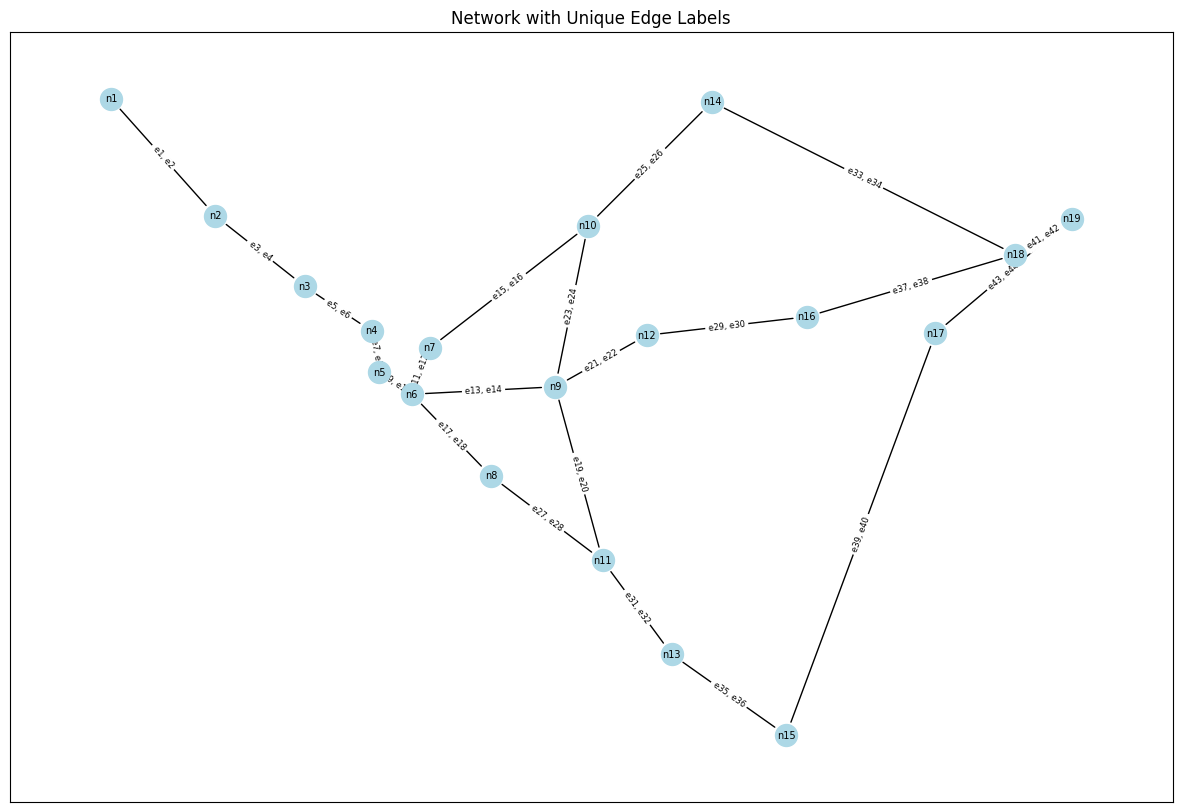

In [2]:
import networkx as nx



# 1. Node numbering (n1, n2, ...)
unique_coords = list(set((row.geometry.x, row.geometry.y) for row in toy_node.itertuples()))
sorted_coords = sorted(unique_coords, key=lambda coord: (coord[0], -coord[1]))

nodes = {f"n{i+1}": coord for i, coord in enumerate(sorted_coords)}

print("Nodes")
for node_name, coords in nodes.items():
    print(f"{node_name}: {coords}")



# 2. Edge numbering (e1, e2, ...)
unique_coords = list(set((row.geometry.x, row.geometry.y) for row in toy_node.itertuples())) # Extract unique coordinates (remove duplicates)
sorted_coords = sorted(unique_coords, key=lambda coord: (coord[1], -coord[0])) # Sort coordinates: First by Y (ascending), then by X (descending)

coord_to_node = {coord: node for node, coord in nodes.items()}

# Collect edges into a list (before sorting)
edge_list = []

for _, row in toy_edge.iterrows():
    line: LineString = row.geometry  
    coords = list(line.coords)  # Extract coordinates from LINESTRING

    for i in range(len(coords) - 1):
        start_coord = coords[i]
        end_coord = coords[i + 1]

        # Match coordinates with nodes
        start_node = coord_to_node.get(start_coord)
        end_node = coord_to_node.get(end_coord)

        if start_node and end_node:
            edge_list.append((start_node, end_node))

edge_list = sorted(edge_list, key=lambda edge: (int(edge[0][1:]), int(edge[1][1:]))) # Sort edges by smallest starting node number

# Create bidirectional edges with correct numbering
edges = {}
arc_id = 1  

for start_node, end_node in edge_list:
    edges[f"e{arc_id}"] = (start_node, end_node)   # Forward edge
    edges[f"e{arc_id+1}"] = (end_node, start_node) # Reverse edge
    arc_id += 2  # Increment by 2 (to maintain odd-even numbering)

print("\nEdges (Properly Ordered & Bidirectional):")
for edge_name, (start_node, end_node) in edges.items():
    print(f"{edge_name}: {start_node} → {end_node}")



# 3. Convert edges to arc format
arcs = [(u, v) for _, (u, v) in edges.items()]



# 4. Compute Euclidean distances
def euclidean_distance(node1, node2):
    x1, y1 = nodes[node1]
    x2, y2 = nodes[node2]
    return round(((x2 - x1)**2 + (y2 - y1)**2)**0.5, 2)

arc_distance = {edge_name: euclidean_distance(u, v) for edge_name, (u, v) in edges.items()}

print("Arc Distances:", arc_distance)



# 5. Create a network graph
# Create the graph using extracted data
G = nx.DiGraph()

# Add nodes and edges
for node, position in nodes.items():
    G.add_node(node, pos=position)

for edge_name, (u, v) in edges.items(): 
    G.add_edge(u, v, weight=arc_distance[edge_name])

# Remove duplicate edges
unique_edges = set()
edge_name_map = {}

for edge_name, (u, v) in edges.items():
    if (v, u) not in unique_edges:  
        unique_edges.add((u, v))
        reverse_edge_name = [k for k, (a, b) in edges.items() if (a, b) == (v, u)]  
        if reverse_edge_name:
            edge_label = f"{edge_name}, {reverse_edge_name[0]}"  
        else:
            edge_label = edge_name  
        
        edge_name_map[(u, v)] = edge_label  

# Plot the network topology
plt.figure(figsize=(15, 10))
pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx_nodes(G, pos, node_size=250, node_color="lightblue")
nx.draw_networkx_edges(
    G, pos,
    edgelist=list(unique_edges),  
    arrowstyle='-',
    min_target_margin=10,
    min_source_margin=10
)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_name_map, font_size=6)
nx.draw_networkx_labels(G, pos, font_size=7)
plt.title("Network with Unique Edge Labels")
plt.show()

In [3]:
import sys
import os
import gc
import re
import json
import copy

# Scientific Libraries
import numpy as np
from scipy.stats import beta

# Optimization
from gurobipy import Model, GRB, quicksum

# Graph & Plotting
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl

# MBNpy Modules
from mbnpy import brc, cpm, variable, operation, branch, config, trans

# Local Module
import batch

# Clean up memory
gc.collect()
%matplotlib inline


C:\Users\Minji Kang\AppData\Local\Temp\ipykernel_8056\4225336150.py:21: DeprecationWarning: operation.py is deprecated and replaced with inference.py. Please update your imports.
  from mbnpy import brc, cpm, variable, operation, branch, config, trans


In [4]:
nodes = nodes  
edges = edges  
arcs = arcs
arc_distance = arc_distance 



# 1. Generate arc failure probabilities based on arc distances (longer distance -> higher failure probability)
# Get the minimum and maximum arc distances
min_dist = min(arc_distance.values())
max_dist = max(arc_distance.values())

# Failure probability range (0.01 ~ 0.1)
min_prob = 0.01
max_prob = 0.1

def compute_failure_probability(distance, min_dist, max_dist, min_prob, max_prob):
    normalized_dist = (distance - min_dist) / (max_dist - min_dist)  # Normalize to [0,1]
    return round(min_prob + normalized_dist * (max_prob - min_prob), 4)

# Generate failure probability for each edge
probs_dynamic = {
    edge: {
        0: compute_failure_probability(dist, min_dist, max_dist, min_prob, max_prob), 
        1: round(1 - compute_failure_probability(dist, min_dist, max_dist, min_prob, max_prob), 4)
    }
    for edge, dist in arc_distance.items()
}

# Sort edges by numeric order
def numeric_sort(edge):
    return int(edge[1:])  # Extract numeric part from "eX"

probs_sorted = {k: probs_dynamic[k] for k in sorted(probs_dynamic, key=numeric_sort)}

# Print formatted probabilities
print(json.dumps(probs_sorted, indent=4, separators=(",", ": ")))
probs = probs_sorted
probs_cpm = copy.deepcopy(probs)
print(probs_cpm)



# 2. Assign capacities to each arcs
# Initial intact capacity (Unchanged from original)
reduced_capacity_edges = {"e10", "e12", "e20", "e21",
                          "e25", "e26", "e42", "e43"}

intact_capacity = {edge: 35 if edge in reduced_capacity_edges else 40 for edge in edges}

# Function to generate random component states (0 or 1) based on failure probabilities
def generate_comps_st(probs):
    comps_st = {}

    for edge, prob in probs.items():
        if isinstance(prob, dict) and 0 in prob and 1 in prob:  # Ensure correct structure
            comps_st[edge] = np.random.choice([0, 1], p=[prob[0], prob[1]])
        else:
            print(f"Warning: Invalid probability format for edge {edge}: {prob}")  # Debugging message

    return comps_st

# Compute arc capacities
comps_st = generate_comps_st(probs_sorted)  # Use directly without JSON conversion
arc_capacity = {edge: int(intact_capacity[edge] * comps_st[edge]) for edge in intact_capacity}

print(json.dumps(arc_capacity, indent=4, separators=(",", ": ")))



# 3. Compute maximum allowable distance
# Demand data
demand = {
    "k1": {"origin": "n10", "destination": "n13", "amount": 32},
    "k2": {"origin": "n2", "destination": "n12", "amount": 34},
    "k3": {"origin": "n10", "destination": "n8", "amount": 15},
    "k4": {"origin": "n7", "destination": "n18", "amount": 35},
    "k5": {"origin": "n17", "destination": "n12", "amount": 40},
    "k6": {"origin": "n18", "destination": "n12", "amount": 49},
    "k7": {"origin": "n19", "destination": "n15", "amount": 42},
    "k8": {"origin": "n10", "destination": "n4", "amount": 49},
    "k9": {"origin": "n16", "destination": "n12", "amount": 43},
    "k10": {"origin": "n10", "destination": "n1", "amount": 17},
    "k11": {"origin": "n3", "destination": "n1", "amount": 30},
    "k12": {"origin": "n4", "destination": "n15", "amount": 38}
}

# Compute max allowable distance
avg_velo = 149  # Speed in km/h
max_distance = {}

for commodity, info in demand.items():
    shortest_distance = nx.shortest_path_length(G, source=info['origin'], target=info['destination'], weight='weight')
    max_allowable_time = (shortest_distance * 60) / avg_velo + 4500  # 9000 minutes extra
    max_distance[commodity] = max_allowable_time * avg_velo / 60  # Store per commodity

    print(f"\nCommodity: {commodity}")
    print(f"  Shortest distance: {shortest_distance} km")
    print(f"  Maximum allowable time: {max_allowable_time:.2f} minutes")
    print(f"  Maximum allowable distance: {max_distance[commodity]:.2f} km")

{
    "e1": {
        "0": 0.0406,
        "1": 0.9594
    },
    "e2": {
        "0": 0.0406,
        "1": 0.9594
    },
    "e3": {
        "0": 0.0327,
        "1": 0.9673
    },
    "e4": {
        "0": 0.0327,
        "1": 0.9673
    },
    "e5": {
        "0": 0.0245,
        "1": 0.9755
    },
    "e6": {
        "0": 0.0245,
        "1": 0.9755
    },
    "e7": {
        "0": 0.01,
        "1": 0.99
    },
    "e8": {
        "0": 0.01,
        "1": 0.99
    },
    "e9": {
        "0": 0.0132,
        "1": 0.9868
    },
    "e10": {
        "0": 0.0132,
        "1": 0.9868
    },
    "e11": {
        "0": 0.0122,
        "1": 0.9878
    },
    "e12": {
        "0": 0.0122,
        "1": 0.9878
    },
    "e13": {
        "0": 0.0469,
        "1": 0.9531
    },
    "e14": {
        "0": 0.0469,
        "1": 0.9531
    },
    "e15": {
        "0": 0.0557,
        "1": 0.9443
    },
    "e16": {
        "0": 0.0557,
        "1": 0.9443
    },
    "e17": {
        "0": 0.0307,
     

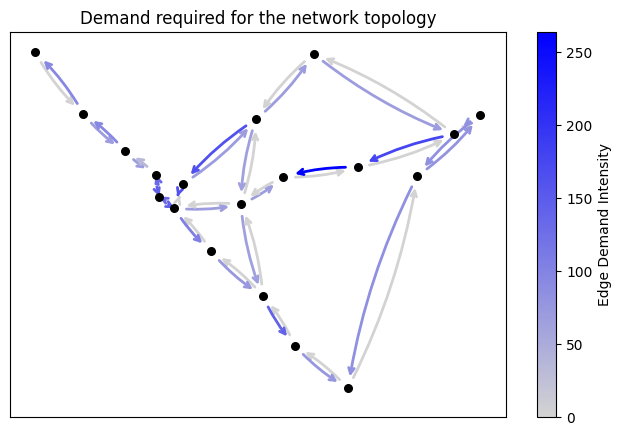

In [5]:
# Compute total demand separately for each edge 
edge_demand = {edge: 0 for edge in edges.keys()}

# Create mapping for bidirectional edges 
bidirectional_mapping = {}
edge_list = list(edges.keys())

for i in range(0, len(edge_list), 2):
    if i + 1 < len(edge_list):
        bidirectional_mapping[edge_list[i]] = edge_list[i + 1]
        bidirectional_mapping[edge_list[i + 1]] = edge_list[i]

# Sum up demand for edges used in any shortest path (all possible shortest paths)
for demand_key, info in demand.items():
    origin, destination, amount = info["origin"], info["destination"], info["amount"]
    try:
        all_paths = list(nx.all_shortest_paths(G, source=origin, target=destination, weight="weight"))
        
        for path in all_paths:
            for i in range(len(path) - 1):
                path_edge = (path[i], path[i + 1])
                for edge_name, (u, v) in edges.items():
                    if path_edge == (u, v):  # Forward direction
                        edge_demand[edge_name] += amount  
                    elif path_edge == (v, u):  # Backward direction
                        reverse_edge = bidirectional_mapping.get(edge_name, edge_name)
                        edge_demand[reverse_edge] += amount  
    except nx.NetworkXNoPath:
        pass  # Ignore cases where no path exists

# Normalize demand values with a small shift (epsilon) to prevent 0
D_max = max(edge_demand.values()) if max(edge_demand.values()) > 0 else 1  # Prevent division by zero
D_min = min(edge_demand.values()) if min(edge_demand.values()) > 0 else 0
epsilon = 0.1  # Small shift to prevent 0 values

normalized_demand = {
    edge: (demand - D_min + epsilon) / (D_max - D_min + epsilon) if D_max != D_min else 0.5
    for edge, demand in edge_demand.items()
}

# Create custom colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list("gray_to_blue", ["lightgray", "blue"])

# Create NetworkX graph
G = nx.DiGraph()
for node, position in nodes.items():
    G.add_node(node, pos=position)
for edge_name, (u, v) in edges.items():
    G.add_edge(u, v, weight=arc_distance[edge_name], label=edge_name)
pos = nx.get_node_attributes(G, "pos")

# Create figure
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_frame_on(True)  # Ensure plot box is visible
nx.draw_networkx_nodes(G, pos, node_size=30, node_color="black", ax=ax)
drawn_edges = set()  # To avoid duplicate plotting

for edge_name, (u, v) in edges.items():
    if edge_name in drawn_edges:
        continue  # Skip if already drawn

    color = cmap(normalized_demand[edge_name])

    # Forward direction (u -> v)
    nx.draw_networkx_edges(
        G, pos, edgelist=[(u, v)], width=2,
        edge_color=[color], edge_cmap=cmap,
        arrowstyle="->", arrowsize=10,
        alpha=1, ax=ax, connectionstyle="arc3,rad=0.08"
    )

    # Reverse direction (v -> u)
    reverse_edge = bidirectional_mapping.get(edge_name, edge_name)
    if reverse_edge != edge_name:  # Ensure backward edge exists
        color_reverse = cmap(normalized_demand[reverse_edge])
        nx.draw_networkx_edges(
            G, pos, edgelist=[(v, u)], width=2,
            edge_color=[color_reverse], edge_cmap=cmap,
            arrowstyle="->", arrowsize=10,
            alpha=1, ax=ax, connectionstyle="arc3,rad=0.08"
        )

    # Mark both forward and backward edges as drawn
    drawn_edges.add(edge_name)
    drawn_edges.add(reverse_edge)

# Colorbar setup
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=D_min, vmax=D_max))
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Edge Demand Intensity")
plt.title("Demand required for the network topology")
plt.show()

In [6]:
def MCNF_systemfunc(arcs, comps_st, edges, arc_capacity, demand, max_distance, arc_distance):
    from gurobipy import Model, GRB, quicksum
    import networkx as nx

    # Create a graph for shortest path calculations
    G = nx.Graph()
    for e, (i, j) in edges.items():
        G.add_edge(i, j, weight=arc_distance.get(e, 1))  # Set edge weights based on distance

    # Create Gurobi optimization model
    model = Model("Network Flow Optimization")
    model.setParam('OutputFlag', 0)

    # Define variables
    flow = {}
    unmet_demand = {}

    for k, info in demand.items():
        unmet_demand[k] = model.addVar(lb=0, vtype=GRB.CONTINUOUS, name=f"unsatisfied_{k}")
        for i, j in arcs:
            arc_key = next((e for e, v in edges.items() if v == (i, j) or v == (j, i)), None)
            capacity = arc_capacity.get(arc_key, 0)
            flow[k, i, j] = model.addVar(lb=0, ub=capacity, vtype=GRB.CONTINUOUS, name=f"flow_{k}_{i}_{j}")

    # Objective function: Minimize expected loss
    cost_coefficient = {
        k: info['amount'] * nx.shortest_path_length(G, source=info['origin'], target=info['destination'], weight='weight') * 0.1723
        for k, info in demand.items()
    }
    
    model.setObjective(
        quicksum(cost_coefficient[k] * unmet_demand[k] for k in demand),
        GRB.MINIMIZE
    )

    # Extract all nodes from edge values
    nodes = set(node for edge in edges.values() for node in edge)

    # Constraint 1: Flow conservation
    for k, info in demand.items():
        origin = info['origin']
        destination = info['destination']
        amount = info['amount']
        for node in nodes: 
            inflow = quicksum(flow[k, i, j] for i, j in arcs if j == node)
            outflow = quicksum(flow[k, i, j] for i, j in arcs if i == node)
            if node == origin:
                model.addConstr(outflow - inflow == amount - unmet_demand[k])
            elif node == destination:
                model.addConstr(outflow - inflow == - amount + unmet_demand[k])
            else:
                model.addConstr(outflow - inflow == 0)

    # Constraint 2: Arc capacity limits
    for i, j in arcs:
        arc_key = next((e for e, v in edges.items() if v == (i, j) or v == (j, i)), None)
        model.addConstr(quicksum(flow[k, i, j] for k in demand if (k, i, j) in flow) <= arc_capacity.get(arc_key, 0))

    # Constraint 3: Commodity별 max_distance 적용
    for k, info in demand.items():
        origin = info['origin']
        distance_expr = quicksum(arc_distance.get(e, 0) * flow[k, i, j] for e, (i, j) in edges.items() if (k, i, j) in flow)
        total_flow = quicksum(flow[k, i, j] for i, j in arcs if (k, i, j) in flow and i == origin)
        
        # max_distance를 dictionary에서 해당 commodity에 맞게 참조
        model.addConstr(distance_expr <= max_distance[k] * total_flow)

    # Perform optimization
    model.optimize()

    # Process results
    if model.status == GRB.OPTIMAL:
        expected_loss = model.objVal

        if expected_loss < 89000000:
            sys_st = 's'

            # We can infer an associated minimum survival rule in case of network connectivity.
            min_comps_st = {}

            # Extract used links from optimization result
            for (k, i, j), var in flow.items():
                if var.x > 0:  # If flow is greater than 0, the edge is used in the solution
                    link_name = next((e for e, v in edges.items() if v == (i, j) or v == (j, i)), None)
                    if link_name:
                        min_comps_st[link_name] = 1  # Store as {e1: 1, e2: 1}

        else:
            sys_st = 'f'
            min_comps_st = None  # No survival rule needed for failed state
        
        return expected_loss, sys_st, min_comps_st  

    else:
        return None, None, None  


In [ ]:
sys_fun = lambda comps_st: MCNF_systemfunc(
    arcs=arcs,
    comps_st=comps_st, 
    edges=edges,
    arc_capacity={edge: intact_capacity[edge] * comps_st[edge] for edge in intact_capacity},  
    demand=demand,
    max_distance=max_distance, 
    arc_distance=arc_distance
)


# Print input values
print("\n🔹 Input Values:")
print("Component States (comps_st):", comps_st)
print("Edges:", edges)
print("Arc Capacity:", arc_capacity)
print("Demand:", demand)
print("Max Distance:", max_distance)
print("Arc Distance:", arc_distance)

# Run the function and capture outputs
expected_loss, sys_st, min_comps_st = sys_fun(comps_st)

# Print output values
print("\n🔹 Output Values:")
print("System State:", sys_st)
print("Minimum component state:", min_comps_st) 


🔹 Input Values:
Component States (comps_st): {'e1': np.int64(1), 'e2': np.int64(1), 'e3': np.int64(1), 'e4': np.int64(1), 'e5': np.int64(1), 'e6': np.int64(1), 'e7': np.int64(1), 'e8': np.int64(1), 'e9': np.int64(1), 'e10': np.int64(1), 'e11': np.int64(1), 'e12': np.int64(1), 'e13': np.int64(1), 'e14': np.int64(1), 'e15': np.int64(1), 'e16': np.int64(1), 'e17': np.int64(1), 'e18': np.int64(1), 'e19': np.int64(1), 'e20': np.int64(1), 'e21': np.int64(1), 'e22': np.int64(1), 'e23': np.int64(1), 'e24': np.int64(1), 'e25': np.int64(1), 'e26': np.int64(0), 'e27': np.int64(1), 'e28': np.int64(1), 'e29': np.int64(1), 'e30': np.int64(1), 'e31': np.int64(0), 'e32': np.int64(1), 'e33': np.int64(0), 'e34': np.int64(1), 'e35': np.int64(1), 'e36': np.int64(1), 'e37': np.int64(1), 'e38': np.int64(1), 'e39': np.int64(1), 'e40': np.int64(1), 'e41': np.int64(1), 'e42': np.int64(1), 'e43': np.int64(1), 'e44': np.int64(1)}
Edges: {'e1': ('n1', 'n2'), 'e2': ('n2', 'n1'), 'e3': ('n2', 'n3'), 'e4': ('n3', '

: 

In [ ]:
# Run BRC with stopping criteria (max_rules = 100)
brs, rules, sys_res, monitor = brc.run(
    probs=probs, 
    sys_fun=sys_fun, 
    max_sf=np.inf, 
    max_nb=np.inf, 
    pf_bnd_wr=0.0, 
    max_rules=100,  
    active_decomp=10,
    display_freq=5,
    brs=[],
)

# Check if BRC stopped due to max_rules
if len(rules['s'] + rules['f']) >= 100:
    print("\n🔹 BRC terminated because 100 rules have been found.")

# System failure probability
P_f = sum(branch.p for branch in brs if branch.down_state == 'f')
print(f"System Failure Probability (P_f): {P_f}")

# Identify failure / unknown branches (brs_u)
brs_u = [branch for branch in brs if branch.down_state == 'u' or branch.up_state == 'u']
brs_f = [branch for branch in brs if branch.down_state == 'f' and branch.up_state == 'f']

print(brs_f)
print(f"Number of failure branches: {len(brs_f)}")

print(rules)

[System function runs 5]..
The # of found non-dominated rules (f, s): 4 (0, 4)
Probability of branchs (f, s, u): (0.0000e+00, 5.31e-01, 4.6854e-01)
The # of branches (f, s, u), (min, avg) len of rf: 71 (0, 6, 65), (0, 0.00)
Elapsed seconds (average per round): 2.02e-01 (4.04e-02)
[System function runs 10]..
The # of found non-dominated rules (f, s): 8 (0, 8)
Probability of branchs (f, s, u): (0.0000e+00, 6.39e-01, 3.6060e-01)
The # of branches (f, s, u), (min, avg) len of rf: 149 (0, 12, 137), (0, 0.00)
Elapsed seconds (average per round): 7.82e-01 (7.82e-02)
[System function runs 15]..
The # of found non-dominated rules (f, s): 13 (0, 13)
Probability of branchs (f, s, u): (0.0000e+00, 7.26e-01, 2.7449e-01)
The # of branches (f, s, u), (min, avg) len of rf: 119 (0, 13, 106), (0, 0.00)
Elapsed seconds (average per round): 1.29e+00 (8.60e-02)
[System function runs 20]..
The # of found non-dominated rules (f, s): 15 (0, 15)
Probability of branchs (f, s, u): (0.0000e+00, 7.81e-01, 2.1932e-

In [ ]:
print("\n🔹 Running Monte Carlo Simulation (MCS) after BRC termination.")

def sys_fun_rs(sample1):
    val, sys_st, _ = sys_fun(sample1)
    return val, sys_st

# Define system variable
varis = {}
for k in edges:
    varis[k] = variable.Variable(name=k, values=[0, 1]) 
varis['sys_event'] = variable.Variable(name='sys_event', values=['f', 's', 'u'])

# Create CPMs for each component event
cpms = {}  # Initialize CPMs
for k, v in edges.items():
    cpms[k] = cpm.Cpm(
        variables=[varis[k]], 
        no_child=1, 
        C=np.array([[0], [1]]),  # Define states (0: fail, 1: survive)
        p=np.array([probs[k][0], probs[k][1]])  # Assign probabilities
    )

# get_composite_state 함수 직접 정의
def get_composite_state(vari, states):
    added = set(states)
    if added not in vari.B:
        vari.B.append(added)
    cst = vari.B.index(added)
    return vari, cst

# mbnpy.variable에 함수 동적으로 추가
import mbnpy.variable as variable
variable.get_composite_state = get_composite_state

# Generate system constraint matrix
Csys, varis = brc.get_csys(brs, varis, {'f': 0, 's': 1, 'u': 2})
Csys = np.array(Csys, dtype=np.int32)  # Ensure integer type

# Ensure "sys_event" exists in CPMs
if "sys_event" not in cpms:
    cpms["sys_event"] = cpm.Cpm(
        variables=[varis["sys_event"]] + [varis[e] for e in edges],
        no_child=1,
        C=np.zeros((1, len(edges) + 1), dtype=int),  # Initialize constraints matrix
        p=np.array([1.0])  # Set initial probability
    )

# Adjust constraint matrix dimensions if needed
expected_columns = len(cpms["sys_event"].variables)
actual_columns = Csys.shape[1]

if actual_columns != expected_columns:
    print(f"⚠ Warning: Adjusting Csys! Expected {expected_columns} columns, but got {actual_columns}.")
    if actual_columns > expected_columns:
        Csys = Csys[:, :expected_columns]  # Trim excess columns
    else:
        missing_cols = expected_columns - actual_columns
        extra_cols = np.full((Csys.shape[0], missing_cols), 0)  # Fill missing columns with 0
        Csys = np.hstack((Csys, extra_cols))

cpms["sys_event"].Cs = Csys  # Assign constraint matrix to CPMs


# Transform unknown branches for MCS
brs_u_transformed = [
    (
        b.down,
        b.up,
        round(float(b.p), 20),  # Convert probability to float and round
        b.down_state,
        b.up_state,
    )
    for b in brs_u
]

# Run Monte Carlo Simulation for unknown branches
cpms, mcs_result = batch.mcs_unknown(
    brs_u=brs_u_transformed,
    probs=probs,
    sys_fun_rs=sys_fun_rs,
    cpms=cpms,
    sys_name="sys_event",
    cov_t=0.01,  # Convergence threshold
    sys_st_monitor=0,  # System failure monitoring state
    sys_st_prob=round(P_f, 20),  # Round system failure probability
    rand_seed=1  # Set random seed for reproducibility
)

# Print MCS results
print(f"\n🔹 MCS Completed. Failure Probability (pf): {mcs_result['pf']:.10e}")
print(f"   - COV: {mcs_result['cov']:.4e}")
print(f"   - Confidence Interval: [{mcs_result['cint_low']:.10e}, {mcs_result['cint_up']:.10e}]")
print(f"   - Number of Samples: {mcs_result['nsamp']}")



🔹 Running Monte Carlo Simulation (MCS) after BRC termination.
brs_u_probs: [0.00010082865736769488, 9.144329762894953e-05, 9.433391347827847e-05, 7.115765020593118e-05, 8.403635617647271e-05, 5.756023696906543e-05, 5.033034356658095e-05, 7.830639083050613e-05, 4.479115817361538e-05, 9.26345860295351e-05, 4.133716147659953e-05, 3.987962021422961e-05, 9.195991291197389e-05, 3.432399160750684e-05, 2.046644016996923e-05, 3.325395284770775e-05, 3.30218117151352e-05, 3.217645171146305e-05, 3.0256549509663e-05, 7.183677925965697e-05, 2.86481691123253e-05, 6.938731423492374e-05, 0.0006514224446116804, 2.62815246988057e-05, 2.602024283809641e-05, 0.0006305114707413056, 0.0006155344651358274, 0.0006127374520209939, 6.082767796053579e-05, 0.0005964528620164631, 0.0005945537343062052, 0.0005818778049790492, 2.316701430767123e-05, 0.000576919341714785, 0.0005754954521885742, 0.0005383411650233038, 0.0005380234287621937, 0.000525390271427293, 1.252915099459921e-05, 0.0004948874172066002, 0.00048063

베타 파이 계산하면서 플롯 업데이트

In [ ]:
def compute_beta_for_combination(probs, X_n):
    failure_probs = [probs[x][0] for x in X_n]
    beta_values = [-norm.ppf(p) for p in failure_probs]
    
    if len(beta_values) == 1:
        joint_prob = failure_probs[0]
        joint_beta = beta_values[0]
    else:
        mean = np.zeros(len(beta_values))
        cov = np.identity(len(beta_values))  
        joint_prob = multivariate_normal.cdf(-np.array(beta_values), mean=mean, cov=cov)
        joint_beta = -norm.ppf(joint_prob) if joint_prob > 0 else float("inf")
    
    return {
        "State": X_n,
        "Failure Probability": joint_prob,
        "Beta": joint_beta
    }

In [ ]:
def compute_pi_for_combination(X_n, probs_cpm, brs_f, brs_u, sys_fun, sys_fun_rs):
    import batch

    P_Xn_0 = [probs_cpm[x][0] for x in X_n]
    P_Xi_0 = np.prod(P_Xn_0)

    # 필터링
    failure_known_branch1, unknown_branch1 = batch.eventspace_multi_x0_filter(brs_u, X_n, P_Xn_0, sys_fun)
    total_prob_failure1 = batch.compute_total_probability(failure_known_branch1)
    B_f = [b for b in brs_f if b.up_state == 'f' and batch.is_xn_all_0(b, X_n)]
    brc_failure_prob1 = batch.compute_total_probability(B_f)

    # MCS
    failure_prob1 = brc_failure_prob1 + total_prob_failure1
    mcs_result = batch.run_mcs_for_unknown_branch(
        brs_u=brs_u,
        unknown_branch=unknown_branch1,
        probs=probs_cpm,
        sys_fun_rs=sys_fun_rs,
        cov_t=0.05, # 원래 0.01이었음
        sys_st_monitor=1,
        failure_prob=failure_prob1,
        rand_seed=None
    )

    joint_prob = mcs_result['pf']
    pi_ratio = joint_prob / P_Xi_0

    # π_ij 계산
    if pi_ratio >= 1 and pi_ratio < 1.01:
        pi_ij = -3
    elif pi_ratio >= 1.01 or pi_ratio <= 0:
        pi_ij = float('inf')
    else:
        pi_ij = -norm.ppf(pi_ratio)
        if pi_ij < -3:
            pi_ij = -3

    return {
        "State": X_n,
        "P(Fsys | state)": pi_ratio,
        "π_ij": pi_ij
    }

: 

In [ ]:
from itertools import combinations
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. 조합 생성
MAX_COMB_SIZE = 2
component_names = list(probs.keys())
component_combinations = []

for k in range(1, MAX_COMB_SIZE + 1):
    component_combinations.extend(list(combinations(component_names, k)))

# 2. 값 저장 리스트
beta_values, pi_values, state_labels, failed_elements = [], [], [], []

# 3. 실시간 플롯 설정
plt.ion()  # 인터랙티브 모드 켜기
fig, ax = plt.subplots(figsize=(8, 8))

# 등고선 (Threshold lines) 고정적으로 그려놓기
prob_targets = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
reverse_labels = [r'$\lambda_{H_j} = 10^{-5}$/year', r'$\lambda_{H_j} = 10^{-4}$/year',
                  r'$\lambda_{H_j} = 10^{-3}$/year', r'$\lambda_{H_j} = 10^{-2}$/year',
                  r'$\lambda_{H_j} = 10^{-1}$/year']
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]

for prob_target, line_style, label in zip(prob_targets, line_styles, reverse_labels):
    beta_threshold = np.arange(-3, 8, 1e-4)
    pi_threshold = -norm.ppf(prob_target / norm.cdf(-beta_threshold))
    ax.plot(pi_threshold, beta_threshold, 'black', linestyle=line_style,
            linewidth=2, label=label, alpha=0.8, zorder=1)

# 색상 및 마커 정의
colors = [(84/255, 102/255, 142/255),
          (54/255, 57/255, 85/255),
          (135/255, 138/255, 198/255)]
markers = ['o', '^', 's']

save_dir = r"D:\MINJI\NETWORK RELIABILITY\Meeting\Figure"
os.makedirs(save_dir, exist_ok=True)  # 폴더가 없으면 자동 생성

# 4. 조합별로 계산 + 실시간 플롯
for idx, X_n in enumerate(component_combinations):
    beta_result = compute_beta_for_combination(probs, X_n)
    pi_result = compute_pi_for_combination(X_n, probs_cpm, brs_f, brs_u, sys_fun, sys_fun_rs)

    β = beta_result['Beta']
    π = pi_result['π_ij']
    k = len(X_n)

    beta_values.append(β)
    pi_values.append(π)
    state_labels.append(",".join(X_n))
    failed_elements.append(k)

    print(f"[{X_n}] → Beta: {β:.4f}, Pi: {π:.4f}")

    # 🔄 5개마다 또는 마지막 조합일 때 plot
    if (idx + 1) % 2 == 0 or (idx + 1) == len(component_combinations):
        fig, ax = plt.subplots(figsize=(8, 8))

        # 등고선
        beta_threshold = np.arange(-3, 8, 1e-4)
        for prob_target, line_style, label in zip(prob_targets, line_styles, reverse_labels):
            pi_threshold = -norm.ppf(prob_target / norm.cdf(-beta_threshold))
            ax.plot(pi_threshold, beta_threshold, 'black', linestyle=line_style,
                    linewidth=2, label=label, alpha=0.8, zorder=1)

        # 지금까지의 누적 점 그림
        for b, p, lbl, kk in zip(beta_values, pi_values, state_labels, failed_elements):
            color = colors[kk - 1]
            marker = markers[kk - 1]
            ax.scatter(p, b, color=color, s=100, edgecolors='k', marker=marker, zorder=3)
            ax.text(p + 0.05, b + 0.05, lbl, fontsize=8, alpha=0.8)

        ax.set_title(r'$\beta$–$\pi$ Diagram: System Evaluation via BRC', fontsize=16)
        ax.set_xlabel("Redundancy (π)", fontsize=12)
        ax.set_ylabel("Reliability (β)", fontsize=12)
        ax.set_xlim([-3, 5])
        ax.set_ylim([-2, 6])
        ax.grid(alpha=0.5)
        ax.legend(title="Failure Thresholds", fontsize=9, loc='lower left')
        plt.tight_layout()

        # ✅ 저장 파일 이름
        filename = f"beta_pi_plot_{idx+1}.jpeg"
        filepath = os.path.join(save_dir, filename)

        # ✅ 저장
        fig.savefig(filepath, dpi=300, format='jpeg')
        plt.close(fig)

[PROB SUM] 0.00002 + 0.00002 + 0.00002 + 0.00002 + 0.00002 + 0.00002 + 0.00002 + 0.00002 + 0.00002 + 0.00002 + 0.00002 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 +

## **Functions for Reliability Index and Redundancy Index**
#### **Beta Calculation**
$$
\beta_{ij} = -\Phi^{-1}\left(P(F_i \mid H_j)\right)
$$

In [ ]:
def calculate_beta(probs):
    MAX_COMB_SIZE = 2  # ✅ 최대 몇 개의 component 조합까지만 계산할지 제한

    # Calculate beta for individual components
    beta = {}
    for edge, probabilities in probs.items():
        failure_prob = probabilities[0]  # P(F_i)
        beta[edge] = -norm.ppf(failure_prob)  # β_i = -Φ^(-1)(P(F_i))

    # Print individual beta values
    print("\nBeta values for each edge:")
    for edge, beta_value in beta.items():
        print(f"Edge {edge}: Beta = {beta_value:.5f}")

    # Define correlation coefficient matrix for n components
    num_edges = len(probs)
    corr_coeff = 0  # Example correlation coefficient
    correlation_matrix = np.full((num_edges, num_edges), corr_coeff)
    np.fill_diagonal(correlation_matrix, 1)  # Diagonal elements are 1

    # Map edge indices to edge names
    edge_names = list(probs.keys())

    # Extract beta values as a list
    beta_values = list(beta.values())

    # Store results
    beta_results = []
    state_combinations = []
    failure_probabilities = []

    # Step 1: Add single-edge failures
    for i, edge in enumerate(edge_names):
        failure_prob = probs[edge][0]  # Failure probability
        beta_value = beta[edge]       # Beta value
        beta_results.append(([edge], failure_prob, beta_value))
        state_combinations.append([edge])
        failure_probabilities.append(failure_prob)

    # Step 2: Add combinations of 2 up to MAX_COMB_SIZE edge failures
    for k in range(2, min(MAX_COMB_SIZE + 1, num_edges + 1)):
        all_combinations = list(combinations(range(num_edges), k))

        for combo in all_combinations:
            beta_k = np.array([beta_values[i] for i in combo])  # Select beta values for this combination
            mean = np.zeros(k)
            cov = correlation_matrix[np.ix_(combo, combo)]  # Submatrix for the selected combination

            # Calculate P(F^k) for this combination
            prob_joint_failure = multivariate_normal.cdf(-beta_k, mean=mean, cov=cov)
            beta_joint_k = -norm.ppf(prob_joint_failure) if prob_joint_failure > 0 else float('inf')

            # Map indices to edge names for the state
            combo_edges = [edge_names[i] for i in combo]

            # Append results
            beta_results.append((combo_edges, prob_joint_failure, beta_joint_k))
            state_combinations.append(combo_edges)
            failure_probabilities.append(prob_joint_failure)

    # Print results for each combination
    print("\nAll beta values for combinations:")
    for state, prob, beta_value in beta_results:
        print(f"Combination {state}: Failure Probability = {prob:.5e}, Beta = {beta_value:.5f}")

    return beta_results, state_combinations, failure_probabilities

beta_results, state_combinations, failure_probabilities = calculate_beta(probs)
df_beta_results = pd.DataFrame(beta_results, columns=['State', 'Failure Probability', 'Beta'])
print(df_beta_results.to_string(index=False)) 


Beta values for each edge:
Edge e1: Beta = 1.74377
Edge e2: Beta = 1.74377
Edge e3: Beta = 1.84251
Edge e4: Beta = 1.84251
Edge e5: Beta = 1.96859
Edge e6: Beta = 1.96859
Edge e7: Beta = 2.32635
Edge e8: Beta = 2.32635
Edge e9: Beta = 2.22028
Edge e10: Beta = 2.22028
Edge e11: Beta = 2.25077
Edge e12: Beta = 2.25077
Edge e13: Beta = 1.67568
Edge e14: Beta = 1.67568
Edge e15: Beta = 1.59193
Edge e16: Beta = 1.59193
Edge e17: Beta = 1.87060
Edge e18: Beta = 1.87060
Edge e19: Beta = 1.80165
Edge e20: Beta = 1.80165
Edge e21: Beta = 1.85079
Edge e22: Beta = 1.85079
Edge e23: Beta = 1.85218
Edge e24: Beta = 1.85218
Edge e25: Beta = 1.68081
Edge e26: Beta = 1.68081
Edge e27: Beta = 1.75069
Edge e28: Beta = 1.75069
Edge e29: Beta = 1.62482
Edge e30: Beta = 1.62482
Edge e31: Beta = 1.89268
Edge e32: Beta = 1.89268
Edge e33: Beta = 1.28155
Edge e34: Beta = 1.28155
Edge e35: Beta = 1.74491
Edge e36: Beta = 1.74491
Edge e37: Beta = 1.49162
Edge e38: Beta = 1.49162
Edge e39: Beta = 1.36836
Edge e

#### **Pi Calculation**

$$
\begin{align*}
\pi_{ij} & = -\Phi^{-1}\left(P(F_{\text{sys}} \mid F_i, H_j)\right) \\
         & = -\Phi^{-1}\left(\frac{P(F_{\text{sys}}, F_i)}{P(F_i)}\right) \\
         & = -\Phi^{-1}\left(
         \frac{
         \sum_{b = (\boldsymbol{l}, \boldsymbol{u}, p) \in B_f : \boldsymbol{u}\langle X_i \rangle = 0} p
         + \sum_{b = (\boldsymbol{l}, \boldsymbol{u}, p) \in B_f : \boldsymbol{u}\langle X_i \rangle = 1 \text{ and } \boldsymbol{l}\langle X_i \rangle = 0} \left(p \cdot P(F_i)\right)
         + \sum_{b = (\boldsymbol{l}, \boldsymbol{u}, p) \in B_f : \boldsymbol{u}\langle X_i \rangle = 1 \text{ and } \boldsymbol{l}\langle X_i \rangle = 1} 0
         }{P(F_i)}
         \right)
\end{align*}
$$

In [ ]:
import importlib
import batch

importlib.reload(batch)

def sys_fun_rs(sample):
    val, sys_st, _ = sys_fun(sample)
    return val, sys_st

: 

In [ ]:
from scipy.stats import norm
import numpy as np
from itertools import combinations

def calculate_pi_brc_sampling(brs_f, brs_u, probs_cpm, sys_fun, sys_fun_rs, MAX_COMB_SIZE=2):
    
    import batch
    pi_ratio = [] 

    component_names = list(probs_cpm.keys())  # All components
    combinations_list = []

    # Generate all component combinations of size 1 to MAX_COMB_SIZE
    for k in range(1, MAX_COMB_SIZE + 1):
        comb_k = list(combinations(component_names, k))
        combinations_list.extend(comb_k)

    for X_n_tuple in combinations_list:
        X_n = X_n_tuple  # Keep as tuple instead of list
        print(f"... Computing for Components: {X_n}")

        # Extract P(X_i = 0) for each component in the combination
        P_Xn_0 = [probs_cpm[x][0] for x in X_n]
        P_Xi_0 = np.prod(P_Xn_0)

        # 문자열로 계산 과정 출력 !!!!!!!!!!!!!!!!!!!!
        terms = [f"{probs_cpm[x][0]:.5f}" for x in X_n]
        calculation_str = " * ".join(terms)
        print(f"P(X_i=0): {calculation_str} = {P_Xi_0:.5e}")

        # Step 1: Unknown branches filtering
        failure_known_branch1, unknown_branch1 = batch.eventspace_multi_x0_filter(brs_u, X_n, P_Xn_0, sys_fun)

        # Step 2: Compute probabilities (Unknown branches / Known branches: F + F from U)
        total_prob_failure1 = batch.compute_total_probability(failure_known_branch1)

        B_f = [branch for branch in brs_f if branch.up_state == 'f' and batch.is_xn_all_0(branch, X_n)]
        print(f"\n🔍 B_f branches where up_state == 'f' and {X_n} == 0:")
        for branch in B_f:
            print(f"  - down       = {branch.down}")
            print(f"  - up         = {branch.up}")
            print(f"  - up_state   = {getattr(branch, 'up_state', 'N/A')}")
            print(f"  - p          = {branch.p:.5e}")
        print(f"➡ Total B_f branches: {len(B_f)}\n")
        brc_failure_prob1 = batch.compute_total_probability(B_f)
        
        # Step 3: Run Monte Carlo Simulation (MCS) for unknown branches
        failure_prob1 = brc_failure_prob1 + total_prob_failure1

        mcs_result_unknown = batch.run_mcs_for_unknown_branch(
            brs_u=brs_u,
            unknown_branch=unknown_branch1,
            probs=probs_cpm,
            sys_fun_rs=sys_fun_rs,
            cov_t=0.01,
            sys_st_monitor=1,
            failure_prob=failure_prob1,
            rand_seed=None
        )

        # Compute conditional probability P(S=0 | X_i=0)
        joint_failure_prob = brc_failure_prob1 + total_prob_failure1 + mcs_result_unknown['pf']
        P_F_given_Xi_0 = joint_failure_prob / P_Xi_0
        print(f"P(F_sys | X_i=0): {P_F_given_Xi_0:.5e}")
        pi_ratio.append((X_n, P_F_given_Xi_0))

    # Calculate π_ij = -Φ^(-1)(P(F_sys | F_i, H_j))
    pi_results = []
    for combination, ratio in pi_ratio:
        if ratio >= 1 and ratio < 1.01:
            # Handle ratios slightly above 1 by capping π_ij to -3
            pi_ij = -3
            print(f"Adjusted ratio for {combination} in range [1, 1.01) to π_ij = -3")
        elif ratio >= 1.01:
            # For larger ratios, handle as NaN or inf
            pi_ij = float('inf')
            print(f"Warning: Ratio for {combination} exceeds 1.01, setting π_ij to inf")
        elif ratio <= 0:
            pi_ij = float('inf')  # Handle invalid or zero ratio
            print(f"Warning: Ratio for {combination} is zero or negative, setting π_ij to inf")
        else:
            # Normal calculation for valid ratios
            pi_ij = -norm.ppf(ratio)
            if pi_ij < -3:
                pi_ij = -3  # Cap minimum value to -3
                print(f"Adjusted π_ij for {combination} to -3")

        pi_results.append({
            'State': combination,
            'P(Fsys | state)': ratio,
            'π_ij': pi_ij
        })

        print(f"✓ Final π_ij for {combination}: {pi_ij:.4f}")

    return pi_results  # Only return the relevant results for DataFrame conversion

# Step 2: π calculation
pi_results = calculate_pi_brc_sampling(brs, brs_u, probs_cpm, sys_fun, sys_fun_rs, MAX_COMB_SIZE=2)
df_pi_results = pd.DataFrame(pi_results)

... Computing for Components: ('e1',)
P(X_i=0): 0.04060 = 4.06000e-02
[PROB SUM] 0.00002 + 0.00002 + 0.00002 + 0.00002 + 0.00002 + 0.00002 + 0.00002 + 0.00002 + 0.00002 + 0.00002 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00001 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 + 0.00000 +

In [ ]:
# Step 1: β calculation
beta_results, state_combinations, failure_probabilities = calculate_beta(probs)
df_beta_results = pd.DataFrame(beta_results, columns=['State', 'Failure Probability', 'Beta'])

# Step 3: Generate β-π Diagram
# Input β and π values
beta_values = df_beta_results['Beta'].values
pi_values = df_pi_results['π_ij'].values
state_labels = df_pi_results['State'].values  # MECE state labels

# Count the number of failed edges
failed_elements = [len(state) for state in state_labels]  # Calculate the number of failed edges in each state


# 색상 및 마커 설정
colors = [(232/255, 232/255, 232/255),
          (245/255, 246/255, 230/255),   
          (84/255, 102/255, 142/255),    
          (54/255, 57/255, 85/255), 
          (135/255, 138/255, 198/255),     
          (89/255, 89/255, 142/255)]   

markers = ['o', '^', 's', 'D', 'P', 'X']  

# Plot 설정
plt.figure(figsize=(8, 8))  # Set the overall plot size

# 각 실패 요소별로 점 그리기
for count, color, marker in zip([1, 2, 3, 4, 5, 6], colors, markers):
    indices = [i for i, x in enumerate(failed_elements) if x == count]
    plt.scatter(np.array(pi_values)[indices], np.array(beta_values)[indices],
                color=color, s=100, label=f"{count} Element Fail",
                marker=marker, edgecolors='k', alpha=1.0, zorder=3)
    
    # 각 점 옆에 state label 추가
   #for idx in indices:
    #   plt.text(pi_values[idx]+0.05, beta_values[idx]+0.05, state_labels[idx],
    #            fontsize=8, ha='left', va='bottom', rotation=20, alpha=0.9)


# Threshold lines for the β-π Diagram
prob_targets = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
reverse_labels = [r'$\lambda_{H_j} = 10^{-5}$/year', r'$\lambda_{H_j} = 10^{-4}$/year',
                  r'$\lambda_{H_j} = 10^{-3}$/year', r'$\lambda_{H_j} = 10^{-2}$/year',
                  r'$\lambda_{H_j} = 10^{-1}$/year']
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]

for prob_target, line_style, label in zip(prob_targets, line_styles, reverse_labels):
    beta_threshold = np.arange(-3, 8, 1e-4)  # Optimize step size
    pi_threshold = -norm.ppf(prob_target / norm.cdf(-beta_threshold))
    plt.plot(pi_threshold, beta_threshold, 'black', linestyle=line_style,
             linewidth=2, label=label, alpha=0.8, zorder=1)

# Plot 커스터마이징
plt.title(r'London Tube $\beta - \pi$ Diagram (BRC Algorithm)', fontsize=16, fontweight='bold')
plt.xlabel('Redundancy (π)', fontsize=12)
plt.ylabel('Reliability (β)', fontsize=12)
plt.xlim([-3, 5])
plt.ylim([-2, 6])
plt.grid(alpha=0.5)
plt.legend(title="Failure Scenarios and Thresholds", fontsize=10, loc="best")
plt.tight_layout()
plt.show()


Beta values for each edge:
Edge e1: Beta = 1.74377
Edge e2: Beta = 1.74377
Edge e3: Beta = 1.84251
Edge e4: Beta = 1.84251
Edge e5: Beta = 1.96859
Edge e6: Beta = 1.96859
Edge e7: Beta = 2.32635
Edge e8: Beta = 2.32635
Edge e9: Beta = 2.22028
Edge e10: Beta = 2.22028
Edge e11: Beta = 2.25077
Edge e12: Beta = 2.25077
Edge e13: Beta = 1.67568
Edge e14: Beta = 1.67568
Edge e15: Beta = 1.59193
Edge e16: Beta = 1.59193
Edge e17: Beta = 1.87060
Edge e18: Beta = 1.87060
Edge e19: Beta = 1.80165
Edge e20: Beta = 1.80165
Edge e21: Beta = 1.85079
Edge e22: Beta = 1.85079
Edge e23: Beta = 1.85218
Edge e24: Beta = 1.85218
Edge e25: Beta = 1.68081
Edge e26: Beta = 1.68081
Edge e27: Beta = 1.75069
Edge e28: Beta = 1.75069
Edge e29: Beta = 1.62482
Edge e30: Beta = 1.62482
Edge e31: Beta = 1.89268
Edge e32: Beta = 1.89268
Edge e33: Beta = 1.28155
Edge e34: Beta = 1.28155
Edge e35: Beta = 1.74491
Edge e36: Beta = 1.74491
Edge e37: Beta = 1.49162
Edge e38: Beta = 1.49162
Edge e39: Beta = 1.36836
Edge e

TypeError: calculate_pi_brc_sampling() got multiple values for argument 'MAX_COMB_SIZE'